In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from testfuncs import Legendre_Polynomials, Finite_Elements
from utils import plot_history, plot_validation
import torch.nn.functional as F

plt.rcParams["figure.autolayout"] = True

## Define the parameters of the equation

In [3]:
f = lambda x: 10  # Source function
k = 2. * (np.pi / 2)  # frequency
a, b = -1., +1.  # Domain
ga, gb = 5., 0.  # Values at the boundaries

## Get the exact solution

In [4]:
from solvers import Exact_HelmholtzImpedance

exact = Exact_HelmholtzImpedance([f(0), 0], k, a, b, ga, gb, source='const')
exact.verify()
u, u_x, u_xx = exact()

# Check that the solution satisfies boundary conditions
assert np.allclose(- u_x(a) - 1j * k * u(a), ga)
assert np.allclose(+ u_x(b) - 1j * k * u(b), gb)
for x in np.linspace(a, b, 100):
    assert np.allclose(- u_xx(x) - k ** 2 * u(x), f(x))

/home/sepeehr/anaconda3/envs/mcss/lib/python3.9/site-packages/scipy/special/orthogonal.py:331: RuntimeWarning: invalid value encountered in double_scalars
  hn *= _gam(n + beta + 1.0) / _gam(n + 1) / _gam(n + ab1)
/home/sepeehr/anaconda3/envs/mcss/lib/python3.9/site-packages/scipy/special/orthogonal.py:332: RuntimeWarning: invalid value encountered in double_scalars
  kn = _gam(2 * n + ab1) / 2.0**n / _gam(n + 1) / _gam(n + ab1)


## Define the model

In [7]:
from solvers import VPINN_HelmholtzImpedance

# Parameters
testfuncs = 30
width = 50
depth = 1

# activation = F.relu
activation = lambda x: F.relu(x).pow(2)
activation.__name__ = 'relu2'

penalty = None
cuda = False
seed = None
dropout_probs = None

# Model
model = VPINN_HelmholtzImpedance(f=f, k=k, a=a, b=b, ga=ga, gb=gb,
                                layers=[1] + [width for _ in range(depth)] + [2],
                                activation=activation,
                                dropout_probs=dropout_probs,
                                penalty=penalty,
                                quad_N=100,
                                seed=seed,
                                cuda=cuda,
                                )
if cuda: model = model.cuda()

testfunctions = Finite_Elements(testfuncs - 1, a, b, dtype=torch.Tensor)
# testfunctions = Legendre_Polynomials(testfuncs - 1, a, b)

file_dir = '../results/VPINN_HelmholtzImpedance/'
experiment_name = f'D{depth:03d}N{width:03d}K{testfuncs:03d}-{testfunctions.__name__}-{activation.__name__}'

## Train the network

### Perfect initialization (to check the network, loss function, etc.)

In [ ]:
points = torch.linspace(a - 1e-06, b, width + 1).float()
derivs = torch.zeros_like(model.lins[1].weight)
for i, point, next in zip(range(width), points[:-1], points[1:]):
    derivs[0, i] = .5 * (u_x(point).real + u_x(next).real)
    derivs[1, i] = .5 * (u_x(point).imag + u_x(next).imag)
steps = derivs.clone()
for i in range(width - 1):
    steps[0, i + 1] = derivs[0, i + 1] - derivs[0, i]
    steps[1, i + 1] = derivs[1, i + 1] - derivs[1, i]

model.lins[0].weight = nn.Parameter(torch.ones_like(model.lins[0].weight))
model.lins[0].bias = nn.Parameter(-1 * points[:-1])
model.lins[1].weight = nn.Parameter(steps.float())
model.lins[1].bias = nn.Parameter(torch.tensor([u(a).real, u(a).imag]).float())

### Train

In [8]:
epochs = 12000

optimizer = optim.SGD([
  # {'params': model.lins[0].weight, 'lr': 5e-03},
  # {'params': model.lins[0].bias, 'lr': 1e-04},
  {'params': model.lins[1].weight, 'lr': 1e-02},
  {'params': model.lins[1].bias, 'lr': 1e-02},
  ], lr=1e-03, momentum=.5)

scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[], gamma=.1, last_epoch=-1)

model.train_(testfunctions(), epochs, optimizer, scheduler, exact=(u, u_x))

file = file_dir + experiment_name + '-train_history.png'
plot_history(
  model.history,
  file,
  )

file = file_dir + experiment_name + '-train_history.json'
with open(file, 'w') as f:
    json.dump(model.history, f)

Epoch 000000 / 12000: loss = 2.532e+00, H1-error = 6.535e+01
Epoch 000100 / 12000: loss = 8.464e+10, H1-error = 7.347e+06


KeyboardInterrupt: 

## Plot the parameters

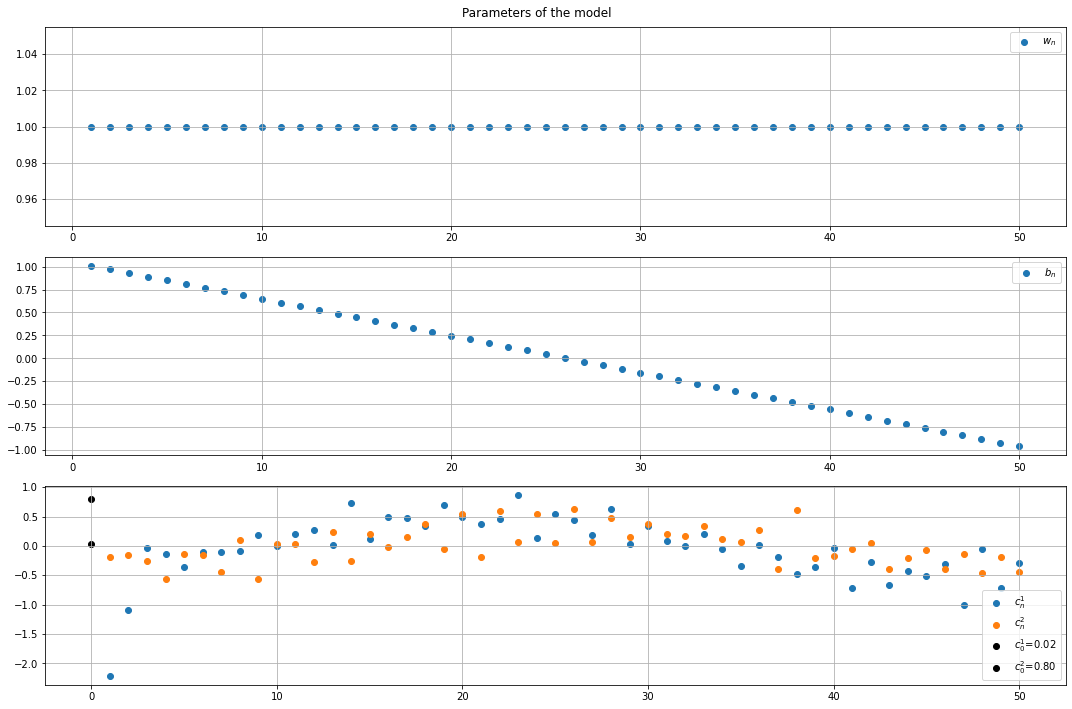

In [10]:
plt.rcParams['figure.figsize'] = [15, 10]
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=4.0)
fig.suptitle(f'Parameters of the model')

axs[0].scatter(np.arange(1, width + 1), model.lins[0].weight.detach().view(-1).numpy(), label='$w_n$')
axs[1].scatter(np.arange(1, width + 1), model.lins[0].bias.detach().view(-1).numpy(), label='$b_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[0].detach().view(-1).numpy(), label='$c^1_n$')
axs[2].scatter(np.arange(1, width + 1), model.lins[1].weight[1].detach().view(-1).numpy(), label='$c^2_n$')
axs[2].scatter(0, model.lins[1].bias[0].detach().view(-1).numpy(), label=f'$c^1_0$={model.lins[1].bias[0].item():.2f}', color='black')
axs[2].scatter(0, model.lins[1].bias[1].detach().view(-1).numpy(), label=f'$c^2_0$={model.lins[1].bias[1].item():.2f}', color='black')
for ax in axs:
    ax.grid()
    ax.legend()

file = file_dir + experiment_name + '-weights.png'
plt.savefig(file)

## Evaluate the results

In [11]:
errs = model.H1_error(u, u_x)

print(f'H1-error: \t\t{errs[0].item():.2e}')
print(f'Solution L2-error: \t{errs[1].item():.2e}')
print(f'Derivative L2-error: {errs[2].item():.2e}')

H1-error: 		3.46e+00
Solution L2-error: 	6.18e-02
Derivative L2-error: 3.39e+00


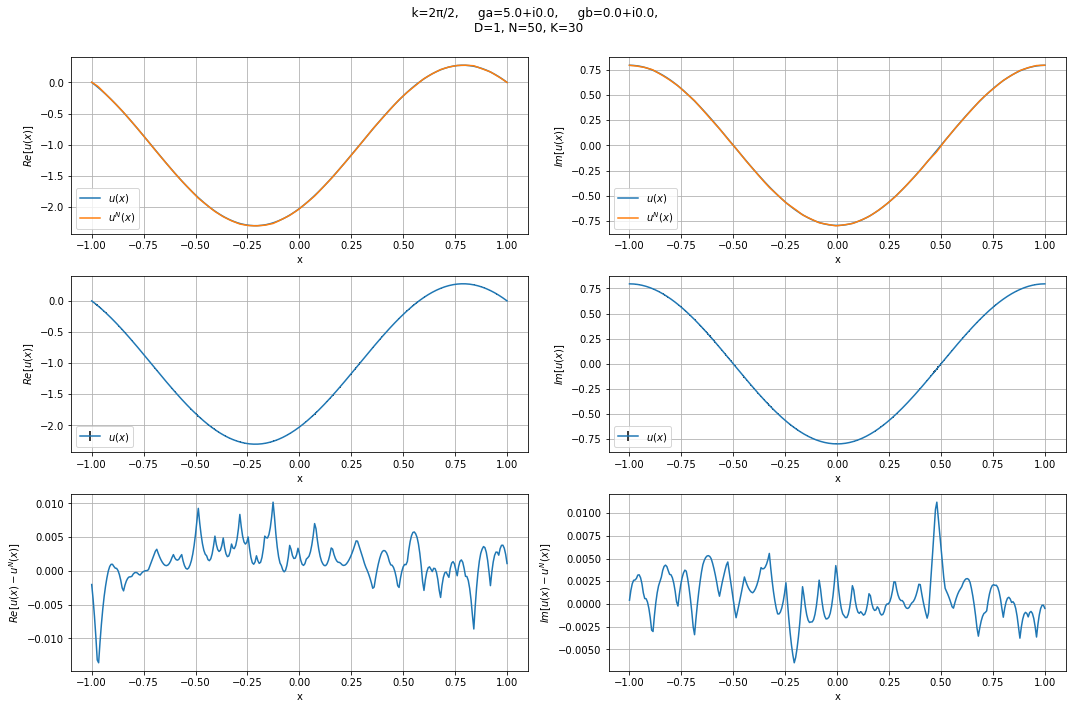

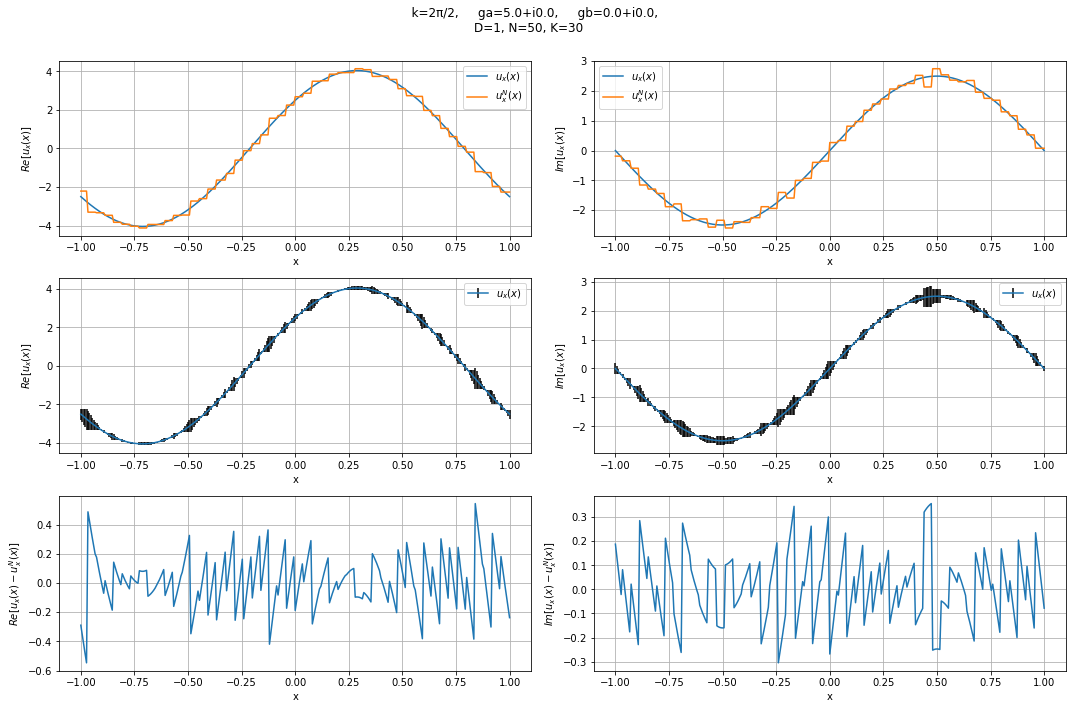

In [12]:
title = f'\
    k={round(model.k.item()/(np.pi/2))}π/2, \
    ga={model.ga_re.item()}+i{model.ga_im.item()}, \
    gb={model.gb_re.item()}+i{model.gb_im.item()}, \
    \nD={depth}, N={width}, K={testfuncs}\
    \n'

model.eval()

xpts = torch.linspace(a, b, 301).float().view(-1, 1)
upts_re, upts_im = u(xpts).real, u(xpts).imag
rpts_re, rpts_im = model.deriv(0, xpts)
with torch.no_grad():
    xpts = xpts.numpy().reshape(-1)
    upts_re = upts_re.numpy().reshape(-1)
    upts_im = upts_im.numpy().reshape(-1)
    rpts_re = rpts_re.numpy().reshape(-1)
    rpts_im = rpts_im.numpy().reshape(-1)

file = '../results/VPINN_HelmholtzImpedance/' + experiment_name + '-sol.png'
plot_validation(
    xpts, (upts_re, upts_im), (rpts_re, rpts_im),
    title=title,
    subscript='',
    file=file,
)

xpts = torch.linspace(a, b, 301).float().view(-1, 1)
upts_re, upts_im = u_x(xpts).real, u_x(xpts).imag
xpts.requires_grad_()
rpts_re, rpts_im = model.deriv(1, xpts)
with torch.no_grad():
    xpts = xpts.numpy().reshape(-1)
    upts_re = upts_re.numpy().reshape(-1)
    upts_im = upts_im.numpy().reshape(-1)
    rpts_re = rpts_re.numpy().reshape(-1)
    rpts_im = rpts_im.numpy().reshape(-1)

file = file_dir + experiment_name + '-der.png'
plot_validation(
    xpts, (upts_re, upts_im), (rpts_re, rpts_im),
    title=title,
    subscript='_x',
    file=file,
)